# Decision Trees

## Table of Contents:
<br>

* ### Preface
<br>
* ### Section 1: Decision Tree Classifier
    • Weather dataset
    <br>
    •  Iris Flower dataset
    <br>
    •  Titanic Dataset
<br>
<br>
* ### Section 2: Decision Tree Regressor
    •  House Price Prediction dataset
<br>
<br>
* ### Section 3: Model Performance Comparison
    •  Sklearn Classifier on Iris Flower dataset
<br>
<br>
* ### Section 4: Hypothesis Testing on Titanic dataset
   

<br>
<br>

* ### References

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Preface

This notebook implements the following:

<br>

* Decision Tree Classifier (ID3) capable of making multi-class classifications using continous and categorical features. The model is tested on the Weather dataset as well as on the Iris and Titanic datasets to demonstrate it's ability of making predictions on datasets that contain both types of features.
<br>

* Decision Tree Regressor capable of making continous values predictions using both numerical and categorical features. Grid-search method is implemented to optimise hyper-parameters on the House price prediction dataset.
<br>

* Sklearn DecisionTreeClassifier is implemented to contextualise performance of the implementation in Section 1. 
<br>

* Hypothesis testing on Titanic dataset

## Section 1: Decision Tree Classifier

The Decision Tree Classifier is implemented using object oriented programming. The main class that instantiates the model is `DecisionTreeClassifier`. <br>
Upon instantiation the `train_test_split` method can be called to get a two way split of the entire dataset: one for training and one for testing. The paremeters to feed in are: 

<br>

* `df`: entire dataset
* `test_size`: percentage of dataset to split [0-1].

<br>

Once datasets have been split, the `fit` method is used to fit the tree on the training dataset. This method takes in parameters:

<br>

* `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* `min_samples_split`: The minimum number of samples required to split an internal node

<br>

The tree is built recursively where at each iteration, method `features_splits` is called to determine the split points for categorical and continuous features. `best_split` is used calculate the best feature to split based on its value which is derived using the following entropy formula in the `weighted_entropy`method: 


\begin{equation*}
Entropy = \sum_{i=1}^c -p_i\log_2{p_i}
\end{equation*}

<br>

The data is then split into left and right nodes/leafs using `data_split` mothod.
<br>

To verify the model's accuracy, method `accuracy_score` can be called on the instantiated model. Predictions are made by the `predict` method which runs through the nodes and compares current values with fitted ones. To further inspect correctness of predictions, method `get_precision_recall` returns the percentage values for Precision (i.e. the number of positive class predictions that belong to the positive class):

\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}

<br>

and Recall (i.e. the number of positive class predictions made out of all positive examples in the dataset): 

\begin{equation*}
Recall = \frac{TP}{TP+FN}
\end{equation*}

Note this method supports binary labels datasets.
<br>
<br>

The `DecisionTreeClassifier` class has a method called `tree_print` that prints out the fitted tree. This method uses multiple attributes to align the node and leaf boxes to form a tree structure. This is printed by looping through a dictionary containing the tree levels as keys and nodes/leafs as lists of string objects. Worth noting that in the interest of outputting a user readible tree structure, for tress with more than 3 levels of depth a nested lists of dictionaries structure is used to print out the tree. Please reference the dataset sections for more detail. 


In [2]:
class DecisionTreeClassifier:
    
    def __init__(self):
        
        self.cols = None
        self.classify_feature_type = None
        self.counter = 0
        self.precision_recall_df = None
    
        # Tree print attibutes
        self.full_tree = {}
        self.current_sate = ''
        self.root_point = int(40 * 1.5)
        self.left_root = int(25 * 1.5)
        self.right_root = int(10 * 1.5)
        self.left_for_right_node = self.root_point
        self.right_for_right_node = int(10 * 1.5)
        self.left_for_left_node = int(30 * 1.5)
        self.right_for_left_node = int(10 * 1.5)
        self.drif = 4 
        self.box_len = 25
        self.level_space = 2
        self.left_state = 0
        self.print_holder = {}
        self.print_leaf = {}
        self.print_tree_higher_depth = None


    
    def get_purity(self,data):

        """
        Function to check purity of labels Y.
        :param data: dataset.
        :return: Boolean true or false.
        """

        labels = data[:, -1]
        unique_labels = np.unique(labels)

        if len(unique_labels) == 1:
            return True
        return False

    
    def classify_data(self,data):

        """
        :input data: dataset.
        :return: most frequent label.
        """

        labels = data[:, -1]
            
        # Classification
        unique_classes, unique_classes_counts = np.unique(labels, return_counts=True)
        index = unique_classes_counts.argmax()
        classification = unique_classes[index]

        return classification

    def features_splits(self,data):

        """
        Determine split points for categorical and continuous features.
        :input data: dataset.
        :return: dictionary of split points by feature.
        """

        splits = {}
        n_rows, n_cols = data.shape
        for idx_col in range(n_cols - 1): # ignore last column as its label
            values = data[:, idx_col]
            unique_entries = np.unique(values)

            # Check if feature is continous or categorical
            feature_type = self.classify_feature_type[idx_col]

            # Continuous feature
            if feature_type == "continuous":
                splits[idx_col] = []
                for idx in range(len(unique_entries)):
                    if idx != 0:
                        current_value = unique_entries[idx]
                        previous_value = unique_entries[idx - 1]
                        potential_split = (current_value + previous_value) / 2
                        splits[idx_col].append(potential_split)

            # Categorical feature
            elif len(unique_entries) > 1:
                splits[idx_col] = unique_entries

        return splits

    def data_split(self, data, col_split, val_split):

        """
        Split continous and categorical data into left and right nodes/leafs. 
        :input data: dataset.
        :input col_split: split dataset columns wise.
        :input val_split: split data left and right based on value.
        :return: left and right datasets.
        """

        split_column_values = data[:, col_split]
        type_of_feature = self.classify_feature_type[col_split]

        # Continuous feature
        if type_of_feature == "continuous":
            left_df = data[split_column_values <= val_split]
            right_df = data[split_column_values >  val_split]

        # Categorical feature 
        else:
            left_df = data[split_column_values == val_split]
            right_df = data[split_column_values != val_split]

        return left_df, right_df


    def entropy(self, data):

        """
        Function to calculate entropy.
        :param data: dataset.
        :return: calculated entropy.
        """

        labels = data[:, -1]
        vals, counts = np.unique(labels, return_counts=True)

        percent_count = counts / counts.sum()
        entropy = sum(percent_count * -np.log2(percent_count))

        return entropy


    def weighted_entropy(self, left_df, right_df):

        """
        Given left and right df calculate full entropy value.
        :input left_df: 'positive' value dataset. 
        :input right_df: 'negative' value dataset.
        :return: weighted entropy
        """

        tot = len(left_df) + len(right_df)
        perc_left_df = len(left_df) / tot
        perc_right_df = len(right_df) / tot

        full_entropy = (perc_left_df * self.entropy(left_df) 
                        + perc_right_df * self.entropy(right_df))

        return full_entropy

    
    def best_split(self, data, splits):

        """
        Function to calculate the best feature, its split point and corresponding value. 
        :input data: dataset. 
        :input splits: dictionary of features and corresponding split points.
        :return: best feature and its value. 
        """

        entropy = np.inf
        for column in splits:
            for value in splits[column]:
                left_df, right_df = self.data_split(data, col_split=column, val_split=value)
                self.current_entropy = self.weighted_entropy(left_df, right_df)
                
                if self.current_entropy <= entropy:
                    entropy = self.current_entropy
                    self.best_split_column = column
                    self.best_split_value = value

        return self.best_split_column, self.best_split_value, self.current_entropy


    def get_feature_type(self,df):

        """
        Function to differentiate features based of data type (categorical, continous)
        :input df: dataframe.
        :return: list of strings for continous and categorical features.
        """

        features_type = []
        for feature in df.columns:
            # Don't include label
            if feature != "Y":
                unique_values = df[feature].unique()
                test_value = unique_values[0]
                # Classify features 
                if (isinstance(test_value, str)):
                    features_type.append("categorical")
                else:
                    features_type.append("continuous")

        return features_type

    
    def fit(self, df, max_depth, min_samples_split):
    
        """
        Function that builds the decision tree recursively.
        :input df: dataframe.
        :input max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until 
                          all leaves contain less than min_samples_split samples.
        :input min_samples_split: The minimum number of samples required to split an internal node
        :return: whole decision tree structure.
        """
        
        # Data preparations
        if self.counter < 1:
            self.cols = df.columns
            self.classify_feature_type = self.get_feature_type(df)
            data = df.values
        else:
            data = df    
        
        # Base case: either pure or breaching thresholds
        if (self.counter == max_depth) | (self.get_purity(data)) | (len(data) < min_samples_split) :
            classification = self.classify_data(data)

            return classification

        # Recursion
        else:    
            self.counter += 1

            # Find split points
            get_splits = self.features_splits(data)
            col_split, self.val_split, self.curr_entropy = self.best_split(data, get_splits)
            left_df, right_df = self.data_split(data, col_split, self.val_split)
            
            # Continous feature
            self.feature_name = self.cols[col_split]
            feature_type = self.classify_feature_type[col_split]            
            
            if feature_type == "continuous":
                tree = "{} <= {}".format(self.feature_name, self.val_split)
                
                # Store data to print tree
                self.print_holder[self.counter] = [self.feature_name, 
                                                   '<=',
                                                   self.val_split, 
                                                   round(self.curr_entropy,2)
                                                  ]
            
            # Categorical feature
            else:
                tree = "{} = {}".format(self.feature_name, self.val_split)
                
                # Store data to print tree
                self.print_holder[self.counter] = [self.feature_name,
                                                   '=',
                                                   self.val_split, 
                                                   round(self.curr_entropy,2)
                                                  ]

            # instantiate sub-tree
            sub_tree = {tree: []}
                        
            # Expand recursion
            left_yes = self.fit(left_df, max_depth, min_samples_split)
            right_no = self.fit(right_df, max_depth, min_samples_split)     
            
            if left_yes == right_no:
                sub_tree = left_yes
            else:
                sub_tree[tree].append(left_yes)
                sub_tree[tree].append(right_no)
        
        # Store tree
        self.print_tree_higher_depth = sub_tree
            
        return sub_tree

    
    def predict(self,data, tree):
        

        """
        Function to predict new data using the fitted tree.
        :input data: data to predict.
        :input tree: fitted tree. 
        :return: predictions
        """

        question = list(tree.keys())[0]
        feature_name, symbol, value = question.split(" ")

        # Continuous festure split question
        if symbol == "<=":  
            if data[feature_name] <= float(value):
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # Categorical feature split question 
        else:
            if str(data[feature_name]) == value:
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # Base case
        if not isinstance(answer, dict):
            return answer

        # Recursion
        else:
            residual_tree = answer
            return self.predict(data, residual_tree)


    def accuracy_score(self, df, tree):

        """
        Given predictions calculate accuracy.
        :input df: dataframe. 
        :input tree: fitted tree. 
        :return: Accuracy figures in text format
        """
        
        # Store predictions
        df["Y_predict"] = df.apply(self.predict, axis=1, args=(tree,))

        # Check if prediction match 
        df["Is_prediction_accurate"] = df["Y_predict"] == df["Y"]
        
        self.precision_recall_df = df.copy()
        
        global a 
        
        a = df.copy()

        # Get mean prediction accuracy 
        mean_accuracy = df["Is_prediction_accurate"].mean()

        accuracy_string = f'The Decision Tree Classifier accuracy is: {round(mean_accuracy,2)*100} %'

        return accuracy_string
    
    
    def calculate_precision_recall(self):
        
        # 0 - 0 true negative
        self.precision_recall_df['True Negative'] = self.precision_recall_df.apply(lambda x: 1 if x['Y'] == 0 and x['Y_predict'] == 0 else 0, axis=1)

        # 0 - 1 false positive
        self.precision_recall_df['False Positive'] = self.precision_recall_df.apply(lambda x: 1 if x['Y'] == 0 and x['Y_predict'] == 1 else 0, axis=1)

        # 1 - 1 true positive 
        self.precision_recall_df['True Positive'] = self.precision_recall_df.apply(lambda x: 1 if x['Y'] == 1 and x['Y_predict'] == 1 else 0, axis=1)

        # 1 - 0 false negative
        self.precision_recall_df['False Negative'] = self.precision_recall_df.apply(lambda x: 1 if x['Y'] == 1 and x['Y_predict'] == 0 else 0, axis=1)

        # Precision = TP/(TP+FP)
        precision = round((self.precision_recall_df['True Positive'].sum()/(self.precision_recall_df['True Positive'].sum()+\
                                                                self.precision_recall_df['False Positive'].sum()))*100,2)
        # Recall TP/(TP+FN)
        recall = round((self.precision_recall_df['True Positive'].sum()/(self.precision_recall_df['True Positive'].sum()+\
                                                                self.precision_recall_df['False Negative'].sum()))*100,2)

        return f"The Decision Tree Classifier has a Precision of {precision}% and Recall of {recall}%"

    
    def train_test_split(self, df, test_size):

        """
        Split data into train and test.
        :param df: entire dataset.
        :param test_size: if < 0 -> % of dataset allocated to test else number of rows.
        return: train and test datasets.
        """

        # Check if test size if float
        if isinstance(test_size, float):
            test_size = round(test_size * len(df))

        idx = df.index.tolist()

        # Get test data
        test_rows = random.sample(population=idx, k=test_size)

        test_df = df.loc[test_rows]
        train_df = df.drop(test_rows)

        return train_df, test_df

    
    def get_dict_tree(self, tree, iter=None):
        
        """
        Get the fitted tree and add structure to the data ready to facilitate the print out.
        :input tree: fitted tree
        :input iter: parameter to count the tree depth
        :return: dictionary to be consumed by tree_print() function.  
        """

        if iter is None:
            iter = 0

        for k, v in tree.items():

            if iter is None:
                iter = 0
                print('ROOT')

            # Is iter key already present?
            if iter not in self.full_tree.keys():
                self.full_tree[iter] = [k]
            else: 
                self.full_tree[iter].append(k)

            iter+=1

            # Root
            if type(v) == dict:
                get_dict_tree(v, iter)

            # Left node
            elif type(v) == list:
                if type(v[0]) == dict:
                    self.get_dict_tree(v[0],iter)

                # Left Leaf
                elif (type(v[0]) == str) or (type(v[0]) == int):
                    if iter not in self.full_tree.keys():
                        self.full_tree[iter] = ['left leaf',v[0]]
                    else: 
                        self.full_tree[iter].extend(['left leaf',v[0]])

                # Right node
                if type(v[1]) == dict:
                    self.get_dict_tree(v[1],iter)

                # Right leaf    
                elif (type(v[1]) == str) or (type(v[1]) == int):
                    if iter not in self.full_tree.keys():
                        self.full_tree[iter] = ['right leaf',v[1]]
                    else:
                        self.full_tree[iter].extend(['right leaf',v[1]])

        return self.full_tree

    
    def tree_print(self, full_tree):
        
        """
        Function to print the decision tree. 
        :input full_tree: Dictionary where keys corresponds to each tree level and values to left and right leaf or node.
        :return: print out of the entire decision tree. 
        """
        
        if self.counter < 4: 
        
            # Loop through each row of the tree
            for k, v in full_tree.items():

                # Root 
                if k == 0:
                    print(' '*self.root_point,'='*(len(v[0])+4))
                    print(' '*self.root_point,' '*((len(v[0])-4)//2),'ROOT',' '*5)
                    print(' '*self.root_point, v[0])
                    print(' '*self.root_point, f"Entropy: {self.print_holder[k+1][3]}")
                    print(' '*self.root_point,'='*(len(v[0])+4),'\n'*self.level_space)
                    self.current_sate = 'root'

                else:

                    for idx, i in enumerate(v):

                        # Dont include root
                        if idx >= 1: 

                            # right node, left node
                            if len(v) == 2:
                                if self.current_sate == 'root':

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len)
                                    print(' '*self.left_root,f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_root,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))
                                    print(' '*self.left_root,v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_root,v[1],' '*(self.box_len - len(v[1])))

                                    print(' '*self.left_root,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len-len(f"Entropy: {self.print_holder[k+1][3]}")),\
                                          ' '*self.right_root,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len - len(v[1])))                                

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len,'\n'*3)

                                    self.current_sate = 'right left node'
                                    break

                                elif self.current_sate == 'right node':

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len)
                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_for_right_node,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))

                                    print(' '*int((self.left_for_right_node+(k-1**self.drif))),v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_right_node,v[1],' '*(self.box_len - len(v[1])))

                                    print(' '*int((self.left_for_right_node+(k-1**self.drif))),self.right_root,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_right_node,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len - len(v[1])))

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len,'\n'*3)

                                    self.current_sate = 'right left node'
                                    break

                                elif self.current_sate == 'left node':

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len)
                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_for_left_node,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_left_node,v[1],' '*(self.box_len - len(v[1])))

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_left_node,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len - len(v[1])))

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len,'\n'*3) 

                                    self.current_sate = 'right left node'
                                    break


                            # left leaf, right node
                            if 'left leaf' == v[0] and len(v) <4:
                                if self.current_sate == 'root':

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len)
                                    print(' '*self.left_root,f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_root,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))

                                    # Numerical                                 
                                    if type(v[1]) == int: # left leaf
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                        else:
                                            v[1] = 'No'

                                    print(' '*self.left_root,v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_root,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*self.left_root,'='*(self.box_len),\
                                          ' '*self.right_root,f" Entropy: {self.print_holder[k+1][3]}")

                                    print(' '*self.left_root,' '*self.box_len, ' '*self.right_root, '='*self.box_len,'\n'*self.level_space)  


                                    self.current_sate = 'right node'
                                    break

                                elif self.current_sate == 'right node':

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len)
                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_for_right_node,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))
                                    # Numerical
                                    if type(v[1]) == int: # left leaf
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                        else:
                                            v[1] = 'No'

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_for_right_node,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node,\
                                          f" Entropy: {self.print_holder[k+1][3]}")

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),' '*self.box_len, ' '*self.right_for_right_node, '='*self.box_len,'\n'*3)

                                    self.current_sate = 'right node'
                                    break

                                elif self.current_sate == 'left node':

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len)
                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_for_left_node,f'RIGHT NODE Level {k}',' '*(self.box_len - len('Right node Level k')))
                                    # Numerical
                                    if type(v[1]) == int: # left leaf
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                        else:
                                            v[1] = 'No'

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_for_left_node,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),'='*self.box_len,\
                                          ' '*self.right_for_left_node), f" Entropy: {self.print_holder[k+1][3]}"

                                    print(' '*int((self.left_for_left_node-((k-1)**self.drif))),' '*self.box_len, ' '*self.right_for_left_node, '='*self.box_len,'\n'*3) 

                                    self.current_sate = 'right node'
                                    break

                            # left node, right leaf
                            if 'right leaf' == v[1] and len(v) <= 4:
                                if self.current_sate == 'root':

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len)
                                    print(' '*self.left_root,f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_root,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))

                                    # Numerical  
                                    if type(v[2]) == int: # right leaf
                                        if v[2] == 1:
                                            v[2] = 'Yes'
                                        else:
                                            v[2] = 'No'

                                    print(' '*self.left_root,v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_root,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*self.left_root,f"Entropy: {self.print_holder[k+1][3]}",' '*(self.box_len-len(f"Entropy:  {self.print_holder[k+1][3]}")),\
                                          ' '*(self.right_root),'='*self.box_len)

                                    print(' '*self.left_root,'='*self.box_len,'\n'*3)

                                    self.current_sate = 'left node'
                                    break

                                elif self.current_sate == 'right node':

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len)
                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_for_right_node,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))
                                    # Numerical
                                    if type(v[2]) == int: # right leaf
                                        if v[2] == 1:
                                            v[2] = 'Yes'
                                        else:
                                            v[2] = 'No'

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_right_node,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),f"Entropy: {self.print_holder[k+1][3]}",\
                                          ' '*((self.right_for_right_node)+(len(v[0]))-7),'='*self.box_len)

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len,'\n'*3)

                                    self.current_sate = 'left node'
                                    break

                                elif self.current_sate == 'left node':

                                    # Adjust k for left node
                                    adjK = k + 1.3

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len)
                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),f'LEFT NODE Level {k}',' '*(self.box_len - len('Left node Level k')),\
                                          ' '*self.right_for_left_node,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))
                                    # Numerical
                                    if type(v[2]) == int: # right leaf
                                        if v[2] == 1:
                                            v[2] = 'Yes'
                                        else:
                                            v[2] = 'No'

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),v[0],' '*(self.box_len - len(v[0])),\
                                          ' '*self.right_for_left_node,v[2],' '*(self.box_len - len(v[2])))

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),f"Entropy: {self.print_holder[k+1][3]}",\
                                          ' '*(self.box_len-len(f" Entropy: {self.print_holder[k+1][3]}")) ,' '*self.right_for_left_node, '='*self.box_len)  

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),'='*self.box_len,'\n'*3)  

                                    self.current_sate = 'left node'
                                    self.left_state += 1
                                    break


                            # right leaf, left leaf (last node)
                            if len(v) == 4:
                                if self.current_sate == 'root':

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len)
                                    print(' '*self.left_root,f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_root,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))
                                    # Numerical
                                    if type(v[1]) == int and type(v[3]) == int: # left and right leafs
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                            v[3] = 'No'
                                        else:
                                            v[1] = 'No'
                                            v[3] = 'Yes'   

                                    print(' '*self.left_root,v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_root,v[3],' '*(self.box_len - len(v[3])))

                                    print(' '*self.left_root,'='*self.box_len, ' '*self.right_root, '='*self.box_len,'\n'*3) 

                                    self.current_sate = 'right left leaf'
                                    break

                                elif self.current_sate == 'right node':

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len)
                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_for_left_node,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))
                                    # Numerical
                                    if type(v[1]) == int and type(v[3]) == int: # left and right leafs
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                            v[3] = 'No'
                                        else:
                                            v[1] = 'No'
                                            v[3] = 'Yes' 

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_for_left_node,v[3],' '*(self.box_len - len(v[3])))

                                    print(' '*int((self.left_for_right_node+(k-1)**self.drif)),'='*self.box_len, ' '*self.right_for_right_node, '='*self.box_len,'\n'*3)  

                                    self.current_sate = 'right left leaf'
                                    break

                                elif self.current_sate == 'left node':
                                    self.left_state +=1

                                    if self.left_state == 2 and k == 3:
                                        # Adjust K for left node
                                        adjK = k + 1.3
                                    else: 
                                        adjK = 1

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len)
                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),f'LEFT leaf Level {k}',' '*(self.box_len - len('Left leaf Level k')),\
                                          ' '*self.right_for_left_node,f'RIGHT leaf Level {k}',' '*(self.box_len - len('Right leaf Level k')))

                                    if type(v[1]) == int and type(v[3]) == int: # left and right leafs
                                        # Numerical
                                        if v[1] == 1:
                                            v[1] = 'Yes'
                                            v[3] = 'No'
                                        else:
                                            v[1] = 'No'
                                            v[3] = 'Yes' 

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),v[1],' '*(self.box_len - len(v[1])),\
                                          ' '*self.right_for_left_node,v[3],' '*(self.box_len - len(v[3])))

                                    print(' '*int((self.left_for_left_node-((adjK-1)**self.drif))),'='*self.box_len, ' '*self.right_for_left_node, '='*self.box_len,'\n'*3)   

                                    self.current_sate = 'right left leaf'
                                    break
        else:
            pprint(self.print_tree_higher_depth, width=50)

## Weather dataset

In [12]:
import time
import random
import numpy as np
import pandas as pd
from pprint import pprint

# Seed to replicate results
random.seed(0)

In [13]:
time_start = time.time()
# Import dataset
data = pd.read_csv('ADD_YOUR_FILE_PATH')

# Assign binary values to target Y using variable decision
data["Y"] = pd.Categorical(data["Decision"]).codes

# Get dataframe 
df = data[['Outlook','Temperature','Humidity','Wind','Y']]

# Instantiate model
model = DecisionTreeClassifier()

# Split dataset into test and train sets
train_df, test_df = model.train_test_split(df, test_size=0.30)

# Fit model 
tree = model.fit(train_df, max_depth = 3, min_samples_split = 2)

# Print model accuracy
accuracy = model.accuracy_score(test_df, tree)

time_end = time.time() - time_start
print(accuracy)
print(f'\nThe time takes to fit the model and calculate its accuracy is {round((time_end),2)} seconds')

The Decision Tree Classifier accuracy is: 100.0 %

The time takes to fit the model and calculate its accuracy is 0.02 seconds


In [14]:
model.calculate_precision_recall()

'The Decision Tree Classifier has a Precision of 100.0% and Recall of 100.0%'

In [15]:
# Print decision tree
dict_tree = model.get_dict_tree(tree)
model.tree_print(dict_tree)

                                                                     ROOT      
                                                             Outlook = Overcast
                                                             Entropy: 0.79


                                      =========================                 =========================
                                      LEFT leaf Level 1                          RIGHT NODE Level 1        
                                      Yes                                        Temperature = Hot         
                                      =========================                  Entropy: 0.8


                                                              =========================                 =========================
                                                              LEFT leaf Level 2                          RIGHT NODE Level 2        
                                                              No                   

## Iris Flower dataset

In [16]:
time_start = time.time()

# Import dataset
df = pd.read_csv("ADD_YOUR_FILE_PATH")

# Drop Id column
df = df.drop("Id", axis=1)

# Rename target as Y 
iris_df = df.rename(columns={"species": "Y"})

# Instantiate model
model = DecisionTreeClassifier()

# Split dataset into test and train sets
train_df, test_df = model.train_test_split(iris_df, test_size=0.30)

# Fit model 
tree = model.fit(train_df, max_depth = 3, min_samples_split = 2)

# Print model accuracy
accuracy = model.accuracy_score(test_df, tree)

time_end = time.time() - time_start
print(accuracy)
print(f'\nThe time takes to fit the model and calculate its accuracy is {round((time_end),2)} seconds')

The Decision Tree Classifier accuracy is: 96.0 %

The time takes to fit the model and calculate its accuracy is 0.03 seconds


In [17]:
dict_tree = model.get_dict_tree(tree)
model.tree_print(dict_tree)

                                                                     ROOT      
                                                             petal_width <= 0.8
                                                             Entropy: 1.55


                                      =========================                 =========================
                                      LEFT leaf Level 1                          RIGHT NODE Level 1        
                                      Iris-setosa                                petal_width <= 1.65       
                                      =========================                  Entropy: 0.97


                                                              =========================                 =========================
                                                              LEFT NODE Level 2                          RIGHT leaf Level 2        
                                                              petal_length <= 4.95

## Titanic dataset

In [18]:
random.seed(3)
time_start = time.time()

# Import data
df = pd.read_csv("ADD_YOUR_FILE_PATH")

# Define target Y
df["Y"] = df.Survived

# Drop unnecessary
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# Handle missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

# Fill in missing values
titanic_df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

# Instantiate model
model = DecisionTreeClassifier()

# Split dataset into test and train sets
train_df, test_df = model.train_test_split(titanic_df, test_size=0.20)

# Fit model 
tree = model.fit(train_df, max_depth = 3, min_samples_split = 2)

# Print model accuracy
accuracy = model.accuracy_score(test_df, tree)

time_end = time.time() - time_start
print(accuracy)
print(f'\nThe time takes to fit the model and calculate its accuracy is {round((time_end),2)} seconds')

The Decision Tree Classifier accuracy is: 83.0 %

The time takes to fit the model and calculate its accuracy is 0.13 seconds


In [19]:
model.calculate_precision_recall()

'The Decision Tree Classifier has a Precision of 79.41% and Recall of 76.06%'

In [20]:
dict_tree = model.get_dict_tree(tree)
model.tree_print(dict_tree)

                                                                 ROOT      
                                                             Sex = male
                                                             Entropy: 0.93


                                      =========================                 =========================
                                      LEFT NODE Level 1                          RIGHT leaf Level 1        
                                      Age <= 13.0                                Yes                       
                                      Entropy: 0.71                             =========================



                  =========================                 =========================
                  LEFT NODE Level 2                          RIGHT leaf Level 2        
                  SibSp <= 2.5                               No                        
                  Entropy: 0.91                             ======================

# Section 2: Decision Tree Regressor

The Decision Tree Regressor has the same underlying architecture of the Classifier with tweaks to make it predict continuous labels using categorical and numerical features. To calculate feature splits, root mean squared error, which is is the standard deviation of the residuals, is used:

\begin{equation*}
RMSE = \sqrt{\frac{\sum_{i=1}^n (x_i - \dot{x_i})^{2}}{N}}
\end{equation*}

Model performance is assessed by method `get_r_squared` which uses the following R squared formula:

\begin{equation*}
R^{2} = 1 - \frac{RSS}{TSS}
\end{equation*}

This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. RSS represents the sum of squared residuals and TSS is the total sum of squares. 
<br>

 `grid_search` method can be used to fine tune hyper-parameters `max_depth` and `min_samples_split`. By exhaustively searching the entire parametes space using nested loops and calls to fit the models and get the corresponding $R^2$ value, this method allows to optimise the DecisionTreeRegressor algorithm performance. 


In [21]:
class DecisionTreeRegressor():
    
        def __init_(self):
            
            self.classify_feature_type = None
            self.col_header = None
                

        def get_purity(self, data):
            
            """
            Function to check purity of labels Y.
            :param data: dataset.
            :return: Boolean true or false.
            """

            label= data[:, -1]
            unique_labels = np.unique(label)

            if len(unique_labels) == 1:
                return True
            return False


        def classify_leaf(self, data):

            label = data[:, -1]
            leaf = np.mean(label)

            return leaf


        def features_splits(self, data):
            
            """
            :input data: dataset.
            :return: most frequent label.
            """

            splits = {}
            idx, n_columns = data.shape
            for col in range(n_columns - 1):
                values = data[:, col]
                unique_vals = np.unique(values)
                splits[col] = unique_vals

            return splits


        def data_split(self, data, col_split, val_split):
            
            """
            Determine split points for categorical and continuous features.
            :input data: dataset.
            :return: dictionary of split points by feature.
            """

            split_values = data[:, col_split]
            type_of_feature = self.classify_feature_type[col_split]
            
            if type_of_feature == "continuous":
                left_df = data[split_values <= val_split]
                right_df = data[split_values >  val_split]

            # feature is categorical   
            else:
                left_df = data[split_values == val_split]
                right_df = data[split_values != val_split]

            return left_df, right_df


        def get_mean_squared_error(self, data):
            
            """
            Calculate the standard deviation of the residuals
            :input data: dataset
            :return: root mean squared error
            """
            

            vals = data[:, -1]

            if len(vals) == 0:
                rmse = 0
            else:
                preds = np.mean(vals)
                rmse = np.mean((vals - preds) **2)

            return rmse


        def get_metric(self, left_df, right_df, function):
            
            """
            Given left and right df calculate RMSE.
            :input left_df: left dataset. 
            :input right_df: 'right dataset.
            :return: weighted RMSE
            """

            tot = len(left_df) + len(right_df)
            perc_left_df = len(left_df) / tot
            perc_right_df = len(right_df) / tot

            metric = (perc_left_df * function(left_df) 
                      + perc_right_df * function(right_df))

            return metric


        def best_split(self, data, splits):
            
            """
            Function to calculate the best feature, its split point and corresponding value. 
            :input data: dataset. 
            :input splits: dictionary of features and corresponding split points.
            :return: best feature and its value. 
            """

            first_cycle = True
            for col in splits:
                for val in splits[col]:
                    left_df, right_df = self.data_split(data, col, val)

                    current_metric = self.get_metric(left_df, right_df, function=self.get_mean_squared_error)

                    if first_cycle or current_metric <= best_metric:
                        first_cycle = False
                        best_metric = current_metric
                        best_column = col
                        best_value = val

            return best_column, best_value


        def feature_type(self, df):
            
            """
            Function to differentiate features based of data type (categorical, continous)
            :input df: dataframe.
            :return: list of strings for continous and categorical features.
            """

            feature_types = []
            values_treshold = 15
            for feature in df.columns:
                if feature != "Y":
                    unique_vals = df[feature].unique()
                    data = unique_vals[0]

                    if (isinstance(data, str)) or (len(unique_vals) <= values_treshold):
                        feature_types.append("categorical")
                    else:
                        feature_types.append("continuous")

            return feature_types


        def fit(self, df, counter=0, max_depth=3, min_samples_split = 2):
        
            """
            Function that builds the decision tree recursively.
            :input df: dataframe.
            :input max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until 
                              all leaves contain less than min_samples_split samples.
            :input min_samples_split: The minimum number of samples required to split an internal node
            :return: whole decision tree structure.
            """

            # data preparations
            if counter == 0:
                self.col_header = df.columns
                self.classify_feature_type = self.feature_type(df)
                data = df.values
            else:
                data = df           


            # base cases
            if (self.get_purity(data)) or (len(data) < min_samples_split) or (counter == max_depth):
                leaf = self.classify_leaf(data)
                return leaf


            # recursive part
            else:    
                counter += 1

                # helper functions 
                splits = self.features_splits(data)
                col_split, val_split = self.best_split(data, splits)
                data_below, data_above = self.data_split(data, col_split, val_split)

                # check for empty data
                if len(data_below) == 0 or len(data_above) == 0:
                    leaf = self.classify_leaf(data)
                    return leaf

                # determine question
                feature_name = self.col_header[col_split]
                feature_type = self.classify_feature_type[col_split]
                if feature_type == "continuous":
                    question = "{} <= {}".format(feature_name, val_split)

                # feature is categorical
                else:
                    question = "{} = {}".format(feature_name, val_split)

                # instantiate sub-tree
                sub_tree = {question: []}

                # find answers (recursion)
                yes_answer = self.fit(data_below, counter, max_depth, min_samples_split)
                no_answer = self.fit(data_above, counter, max_depth, min_samples_split)

                if yes_answer == no_answer:
                    sub_tree = yes_answer
                else:
                    sub_tree[question].append(yes_answer)
                    sub_tree[question].append(no_answer)

                return sub_tree
            
            
        def predict(self, data, tree):
            
            """
            Function to predict new data using the fitted tree.
            :input data: data to predict.
            :input tree: fitted tree. 
            :return: predictions
            """
                        
            qq = list(tree.keys())[0]
            feature_name, operator, value = qq.split(" ")
            
            # ask question
            if operator == "<=":
                if data[feature_name] <= float(value):
                    answer = tree[qq][0]
                else:
                    answer = tree[qq][1]

            # feature is categorical
            else:
                if str(data[feature_name]) == value:
                    answer = tree[qq][0]
                else:
                    answer = tree[qq][1]

            # base case
            if not isinstance(answer, dict):
                return answer

            # recursive part
            else:
                residual_tree = answer
                return self.predict(data, residual_tree)
        
        
        def get_r_squared(self, df, tree):    
            
            """
            Calculate the residual sum of squares.
            :input df: dataset.
            :input tree: fitted tree.
            :return: residual sum of squares. 
            """
            
            labels = df.Y
            mean = labels.mean()
            preds = df.apply(self.predict, args=(tree,), axis=1)

            ss_res = sum((labels - preds) ** 2)
            ss_tot = sum((labels - mean) ** 2)
            r_squared = 1 - ss_res / ss_tot

            return r_squared
        
        def train_test_split(self, df, test_size):

            """
            Split data into train and test.
            :param df: entire dataset.
            :param test_size: if < 0 -> % of dataset allocated to test else number of rows.
            return: train and test datasets.
            """

            # Check if test size if float
            if isinstance(test_size, float):
                test_size = round(test_size * len(df))

            idx = df.index.tolist()

            # Get test data
            test_rows = random.sample(population=idx, k=test_size)

            test_df = df.loc[test_rows]
            train_df = df.drop(test_rows)

            return train_df, test_df

        
        def grid_search(self, 
                        train_df, 
                        test_df,
                        max_depth_min=1, 
                        max_depth_max=7, 
                        min_samples_split_min=5, 
                        min_samples_split_max=20,
                        steps=5
                       ):
            
            """
            Iterative function that exhaustively loops through the parameter space testing the performance
            of each parameter setting. 
            :input train_df: train dataset.
            :input test_df: test dataset.
            :input max_depth_min: max_depth floor value. 
            :input max_depth_max: max_depth ceiling value.
            :input min_samples_split_min: min_samples_split_min floor value.  
            :input min_samples_split_max: min_samples_split_min ceiling value. 
            :input steps: step value used in range loop. 
            :return: dataframe with train and test R^2 values for each parameter setting.  
            """

            grid_search = {"max_depth": [], 
                           "min_samples_split": [], 
                           "r_squared_train": [], 
                           "r_squared_test": []
                          }

            # Set values to loop through
            for max_depth in range(max_depth_min, max_depth_max):
                for min_samples_split in range(min_samples_split_min, min_samples_split_max, steps):

                    # Fit model 
                    tree = model.fit(train_df, max_depth=max_depth, min_samples_split=min_samples_split)

                    # Calculate R squared for train test
                    r_squared_train = model.get_r_squared(train_df, tree)
                    r_squared_test = model.get_r_squared(test_df, tree)

                    # Append values 
                    grid_search["max_depth"].append(max_depth)
                    grid_search["min_samples_split"].append(min_samples_split)
                    grid_search["r_squared_train"].append(r_squared_train)
                    grid_search["r_squared_test"].append(r_squared_test)

                #print(f"Epoch number:  {max_depth}/{max_depth_max-max_depth_min-1}")

            grid_search = pd.DataFrame(grid_search)
            grid_search.sort_values("r_squared_test", ascending=False).head()

            return grid_search

##  House Price Predicition dataset

In [22]:
time_start = time.time()

random.seed(108)

# Import dataset
df = pd.read_csv("ADD_YOUR_FILE_PATH")

# Set Y label
df['Y'] = df.price.copy()

# Select features
df = df[['bedrooms','bathrooms','sqft_living','floors','waterfront','sqft_lot','condition','yr_built','Y']]

# Instantitate model
model = DecisionTreeRegressor()

# Split dataset into test and train sets
train_df, test_df = model.train_test_split(df, test_size=0.1)

# Fit model
tree = model.fit(train_df, max_depth = 5, min_samples_split = 10)
pprint(tree)

time_end = time.time() - time_start
print(accuracy)
print(f'\nThe time takes to fit the model is {round((time_end),2)} seconds')

{'sqft_living <= 2910.0': [{'sqft_living <= 2080.0': [{'bathrooms <= 1.0': [{'yr_built <= 1929.0': [{'sqft_living <= 900.0': [302523.2275565319,
                                                                                                                              440168.7106807535]},
                                                                                                    {'yr_built <= 1955.0': [321708.5557862696,
                                                                                                                            258936.67930629101]}]},
                                                                            {'sqft_lot <= 7793.0': [{'sqft_lot <= 7790.0': [439730.21171713696,
                                                                                                                            26590000.0]},
                                                                                                    {'sqft_living <= 1651.0': [345265.9

This section explains how the above decision tree can be read. 
<br>
`sqft_living <= 2910.0` is the root node. From there it branches off with two nodes, `sqft_living <= 2080.0` if the answer to the node question is positive and `sqft_living <= 6070.0` if negative. 
<br>
Taking the positive node as an example you then encounter two nodes `'bathrooms <= 1.0` if the answer to `sqft_living <= 2080.0`is positive or `yr_built <= 1956.0` if otherwise. 
<br>
Assuming the answer is negative you then have two more nodes: `yr_built <= 1955.0` if the answer to `yr_built <= 1956.0` is positive and `sqft_living <= 2600.0` if the answer is negative. 
<br>
If the house was built before 1955 we then arrive at node `floors = 2.0` which has two leafs. If the house has two floors the predicted price is 858040.78 otherwise 668138.09.

In [23]:
random.seed(108)
r_squared_train = model.grid_search(train_df, test_df)
r_squared_train.sort_values(by=['r_squared_train', 'r_squared_test'],ascending=False).head(1)

,max_depth,min_samples_split,r_squared_train,r_squared_test
15,6,5,0.765596,0.588987


# Section 3: Model Performance Comparison

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Sklearn Classifier on Iris Flower dataset

In [25]:
time_start = time.time()

# Split features and labels 
X = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width' ]]
y = iris_df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=128)

# Initialise Decision Tree
tree_model = DecisionTreeClassifier() 
 
# Fit model
tree_model = tree_model.fit(X_train, y_train)

# Evaluate Model
y_pred = tree_model.predict(X_test)

# Calculate accuracy 
acc_secore = round(accuracy_score(y_pred, y_test), 3)
print('Accuracy: ', round((acc_secore* 100),2),'%')

time_end = time.time() - time_start
print(f'\nThe time takes to fit the model and calculate its accuracy is {round((time_end),2)} seconds')

Accuracy:  93.3 %

The time takes to fit the model and calculate its accuracy is 0.0 seconds


## Section 4: Hypothesis Testing on Titanic dataset

In the following section a statistical answer to the question 'Did people in First class have a better chance of survival than people in Third' will be provided. To achive this a Null and Altrnative hypothesis are set as follow: 

\begin{equation*}
H_o: People \ in \ First \ class \ had \ same \ chance \ of \ survival \ than \ in \ Third
\end{equation*}
<br>
\begin{equation*}
H_1: People \ in \ First \ class \ had \ higher \ chance \ of \ survival \ than \ in \ Third
\end{equation*}

<br>

Next we look at the data and see what results we get:

In [26]:
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

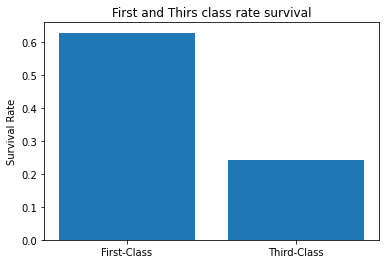

In [27]:
x = ["First-Class", "Third-Class"]

# Mean values of First and Third class 
y = [np.mean(titanic_df["Y"][titanic_df["Pclass"]==1]), np.mean(titanic_df["Y"][titanic_df["Pclass"]==3])]

plt.bar(x, y)
plt.ylabel("Survival Rate")
plt.title("First and Thirs class rate survival")
plt.show()

Looking at the plot above, it’s quite clear that First class people had a higher rate of survival. However, this conclusion could be classified as invalid this data is just a sample and dont know if datapoints are random, unbiased and representative of the entire population. 
<br>
<br>
This is where Hypothesis testing come into play. Hypothesis testing is used to check if the observed difference between the two populations is significant or is just due to some randomness in the data.
<br><br>
For this exercise a Z-Score test will be used to conduct the significance test and see if the null hypothesis should be rejected or accepted.
<br><br>
For the z-test to work, the probability distribution of the survival rate of the first-class people and the probability distribution of the survival rate for the third-class both have to be normally distributed. Let's check if this is the case:

In [40]:
first_sample = np.array([np.mean(titanic_df[titanic_df["Pclass"]==1].sample(20)["Y"].values) for i in range(100)])
third_sample = np.array([np.mean(titanic_df[titanic_df["Pclass"]==3].sample(20)["Y"].values) for i in range(100)])

According to the central limit theorem, our two sample populations should be approximately normally distributed:

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


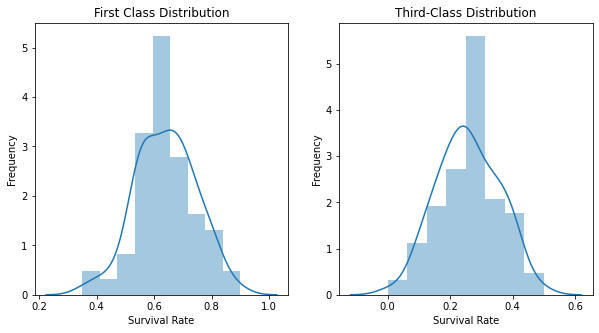

In [42]:
plt.subplots(1, 2, figsize = (10, 5))
plt.subplot(1,2, 1)
sns.distplot(first_sample)
plt.title("First Class Distribution")
plt.xlabel("Survival Rate")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
sns.distplot(third_sample)
plt.title("Third-Class Distribution")
plt.xlabel("Survival Rate")
plt.ylabel("Frequency")
plt.show()

According to the sample distributions, the effect of the First to Third class is 0.6296–0.2423 = 0.3873
<br><br>
The z-test checks the significance of this effect by calculating the z-score which is measurement of how many standard deviations a value is from the mean. Tthe higher the z-score, the further the value from the mean and therefore on the extreme sides of the distribution curve.
<br>
The Z-Score is then turned into the P-value which is the probability of observing that effect given that the null hypothesis is true. In other words, if the P-value is high then we can accept the Null hypothesis since the probability of obtaining that extreme difference in the survival rate (even though when the class doesn’t have an effect) is high.
<br>
A value of Alpha also needs to be set as a threshold for rejecting the Null hypothesis. For this experiment a level of 0.05 will be set. If the P-value is lower than that level, then the null hypothesis can be rejected.
<br>
Next the Z-Score can be calculate using the following formula: 


\begin{equation*}
Z = \frac{\mu _{1}-\mu_{3}}{\sigma_{1-3}}
\end{equation*}

<br>

where

μ₁ is the mean of the First class
<br>
μ₃ is the mean of the Third class 
<br>
σ₁₋₃ is the standard deviation of the differences between the two populations

<br><br>

Worth noting that these parameters don't represent the entire population. Since the dampleset is sufficently large then the standard deviations of each of these samples can be considered as a good approximation to the true population standard deviation using the following formula:

<br>

\begin{equation*}
\sigma_{1-3} = \sqrt{\frac{\sigma_{1}^{2}}{n}+\frac{\sigma_{3}^{2}}{m}}
\end{equation*}

<br>

where

σ₁ is the standard deviation of the First class sample distribution
n is the First class sample distribution size
σ₃ is the standard deviation of the Third class sample distribution
m is the Third class sample distribution size

In [47]:
# Calculate mean difference
effect = np.mean(first_sample) - np.mean(third_sample)

# Get First class sigma
first_sigma = np.std(first_sample)

# Get Third class sigma
third_sigma = np.std(third_sample)

# Delta sigma 
sigma_difference = np.sqrt((first_sigma**2)/len(first_sample)  +  (third_sigma**2)/len(third_sample))
z_score = round((effect / sigma_difference),2)
z_score

26.62

The z-score above is 26.62 which is an very high score. THe cell below calculates the P-value:

In [51]:
# Get P-value
st.norm.sf(abs(z_score))*2

3.983712211029806e-156

The P-value is 3.98e-156 which is considerably smaller than the level of 0.05 that we set. What this P-value indicates is if we assume that the null hypothesis is true, then the probability of observing that effect by random is 3.98e-156% which is an extremely small probability that makes us comfortable in rejecting the Null hypothesis.

## References

<br>

• Iris Flower dataset: https://www.kaggle.com/datasets/arshid/iris-flower-dataset
<br>
• Titanic dataset: https://www.kaggle.com/datasets/yasserh/titanic-dataset
<br>
• House Price Prediction dataset: https://www.kaggle.com/datasets/shree1992/housedata
<br>
• Sklearn - Decision Tree Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
<br>
• Sklearn - Decision Tree Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html